<a href="https://colab.research.google.com/github/ematala/satellite-segmentation/blob/main/SlidingWindowPadding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import math
import numpy
import matplotlib.pyplot as plt

#!pip install catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

In [2]:
# Class Names
classes = numpy.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland',
                    'Water', 'Wetlands', 'Tundra', 'Artificial Surface',
                    'Bareland', 'Snow and Ice'])

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# load training data from npz file
data = numpy.load('/content/gdrive/MyDrive/train.npz')
bands = data['bands']
labels = data['lulc']

In [3]:
# load test data from npz file
public_test_data = numpy.load('/content/gdrive/MyDrive/public_test.npz')
test_bands = public_test_data['bands']

## Exploratory

In [ ]:
n_months = 12
n_classes = len(classes)
n_channels = 6

In [ ]:
# Check for RGB Values in range
for month in range(n_months):
  rgb_img = test_bands[month][:, :, (2,1,0)]
  mean = rgb_img.mean()
  print(rgb_img.max(),"max")
  print(rgb_img.min(),"min")

In [ ]:
# plot the train set
f, axes = plt.subplots(1, n_months, figsize=(200,200))

for month in range(n_months):
    axes[month].imshow(test_bands[month][:, :, 0:3])

In [ ]:
# plot the test set
f, axes = plt.subplots(1, n_months, figsize=(300,300))

for month in range(n_months):
    axes[month].imshow(padded_bands[month][:, :, 0:3])

# Temporary CNN for Testing

In [ ]:
# Tom CNN 

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.utils.np_utils import to_categorical

model = Sequential()
model.add(Conv3D(32, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(12,33,33,6)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Conv3D(64, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(11, activation='softmax'))

# Compile the model
model.compile(
    'Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 12, 31, 31, 32)    1760      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 6, 15, 15, 32)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 15, 15, 32)     128       
_________________________________________________________________
dropout (Dropout)            (None, 6, 15, 15, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 6, 13, 13, 64)     18496     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 6, 6, 64)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 6, 6, 64)       2

In [ ]:
from sklearn.model_selection import train_test_split

# separate bands and labels:
train_data = data['bands']
labels = data['lulc']

# remove no_data
labels_no_data = labels[labels != 0]
train_data_no_data = train_data[labels != 0, :, :, :, :]

train = {}
validation = {}
# with no_data removed
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train_data_no_data, labels_no_data, test_size=0.2, random_state=0)

val = validation['labels']
train['labels'] = to_categorical(train['labels'], 11)
validation['labels'] = to_categorical(validation['labels'], 11)

In [ ]:
# Fit model
history = model.fit(train['features'], train['labels'], batch_size=64, epochs=50, validation_data=(validation['features'], validation['labels']))

Epoch 1/50
109/109 [==============================] - 6s 45ms/step - loss: 0.5075 - accuracy: 0.8251 - val_loss: 1.5985 - val_accuracy: 0.6947
Epoch 2/50
109/109 [==============================] - 4s 40ms/step - loss: 0.4324 - accuracy: 0.8463 - val_loss: 1.3234 - val_accuracy: 0.7309
Epoch 3/50
109/109 [==============================] - 4s 40ms/step - loss: 0.4014 - accuracy: 0.8626 - val_loss: 1.3994 - val_accuracy: 0.7148
Epoch 4/50
109/109 [==============================] - 4s 40ms/step - loss: 0.3586 - accuracy: 0.8783 - val_loss: 1.4225 - val_accuracy: 0.6947
Epoch 5/50
109/109 [==============================] - 4s 40ms/step - loss: 0.3296 - accuracy: 0.8826 - val_loss: 1.2893 - val_accuracy: 0.7309
Epoch 6/50
109/109 [==============================] - 4s 40ms/step - loss: 0.3136 - accuracy: 0.8894 - val_loss: 1.8652 - val_accuracy: 0.7355
Epoch 7/50
109/109 [==============================] - 4s 40ms/step - loss: 0.2859 - accuracy: 0.9028 - val_loss: 1.6661 - val_accuracy: 0.7263

In [ ]:
model.save('/content/gdrive/MyDrive/DummyModel')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/DummyModel/assets


# Padded Sliding Window

Case 1: Load CNN Model

In [4]:
import keras
from keras.models import load_model

model = keras.models.load_model("/content/gdrive/MyDrive/DummyModel")

Case 2: Create CatBoost Model

In [ ]:
# use only labelled data for training
x_train, x_val, y_train, y_val = preprocess(bands, labels, 'exclude_no_data')
f'train: {x_train.shape} {y_train.shape}, validation: {x_val.shape} {y_val.shape}'

cbm_v2 = CatBoostClassifier(learning_rate=0.1, iterations=1000, random_seed=42, logging_level='Verbose', task_type='GPU')
cbm_v2.fit(x_train, y_train)

Predict on Test Set using the Sliding Window Approach.

Patch Width Parameter must match expected Input Shape when used with CNN Models.

Batch Size Parameter is currently unused

In [7]:
# Test call Slidign Window Function
print(slidingWindowPrediction(model, test_bands, 0, 33))

[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


In [6]:
def slidingWindowPrediction(model, test_data, batch_size, patch_width):
  """
  This function enables predicting datasets that are bigger than
  the training data. 
  """


  #config = model.get_config()
  #patch_width = config["layers"][0]["config"]["batch_input_shape"]

  patches = []
  predictions = []
  test_size = test_data.shape[1]

  # Augment Data with mirrored padding to keep structure for points on the edge
  pad_width = int( (patch_width - 1) / 2 )
  padded_bands = []

  for month in range(12):
      padded_bands.append(numpy.pad(test_data[month], ((pad_width,pad_width), (pad_width,pad_width), (0,0)), "symmetric"))

  padded_bands = numpy.asarray(padded_bands)

  # Predict labels in batches 
  for h in range(test_size):
    # Collect all patches for one row
    for w in range(test_size):
      current_patch = padded_bands[:, h:h+patch_width, w:w+patch_width, :]
      
      # if CatBoost, reshape patch
      if(isinstance(model, CatBoostClassifier)):
        patch_center = math.floor(patch_width/2)
        center_point_month_and_channel = current_patch[:,patch_center,patch_center,:]
        center_point = center_point_month_and_channel.reshape((1,6*12))
        patch_mean = numpy.mean(current_patch, axis=(2,3))
        #print(patch_mean.shape)
        patch_mean_reshaped = numpy.reshape(patch_mean,(1,12*6))
        current_patch = numpy.concatenate((patch_mean_reshaped, center_point), axis=1)

      #print(current_patch.shape)
      patches.append(current_patch)


    # Predict batch of patches
    temp_preds = model.predict(numpy.asarray(patches))

    # Add batch prediction to result array
    for pred in temp_preds:
        predictions.append(numpy.argmax(pred))
    patches = []

  predictions = numpy.asarray(predictions)
  predictions = predictions.reshape((test_size, test_size))
  return predictions

In [9]:
def preprocess(x, y, labels=None):
  # set the pixel to extract
  PIXEL_X = 16
  PIXEL_Y = 16
  
  x = x[y != 0, :, :, :, :] if labels == 'exclude_no_data' else x[y == 0, :, :, :, :] if labels == 'only_no_data' else x
  y = y[y != 0] if labels == 'exclude_no_data' else y[y == 0] if labels == 'only_no_data' else y

  x_train, x_val, y_train, y_val = train_test_split(x[:, :, PIXEL_X, PIXEL_Y, :].reshape((x.shape[0], x.shape[1] * x.shape[-1])), y, test_size=0.2, random_state=42, stratify = y)

  return x_train, x_val, y_train, y_val

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


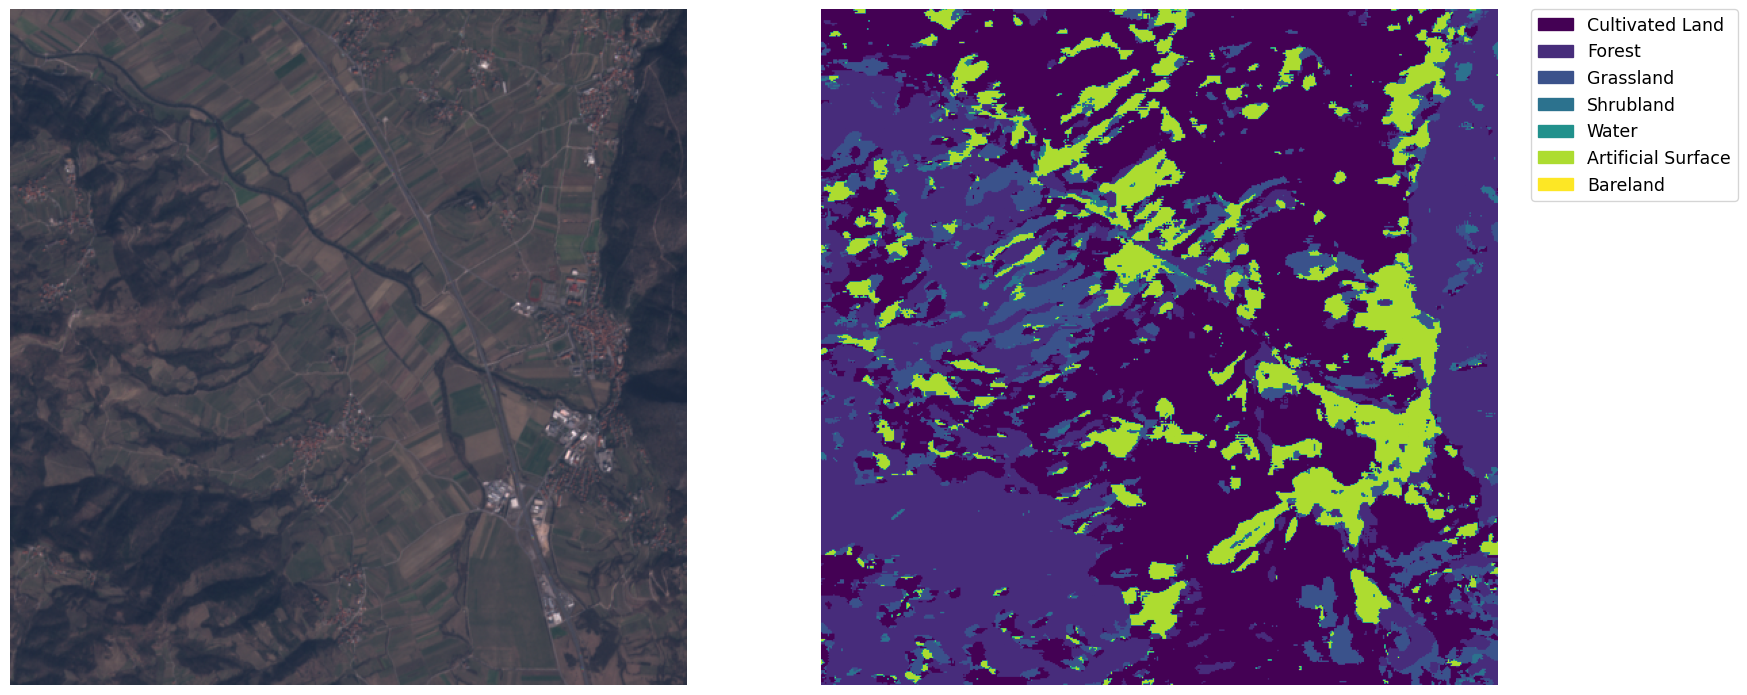

In [ ]:
#!pip install earthpy
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20), dpi=96)

# Plot correct image:
### Load September
band_sep = test_bands[2,:,:,:3]
### Flip from BGR to RGB
band_flip = numpy.flip(band_sep, -1)
### Change Bridness
band_bright = band_flip + .3
### Change Contrast
c_fact = 2.5
band = 0.5 + c_fact * (band_bright - 0.5)
ax1.axis('off')
ax1.imshow(band, cmap='gray')


# Plot prediction
#im_arr = lgb_predictions_testset.reshape(500, 500)
labels_indices = numpy.unique(predictions)
used_labels = numpy.take(classes, labels_indices).tolist()

im_ax2 = ax2.imshow(predictions)
leg_neg = ep.draw_legend(im_ax = im_ax2, titles = used_labels)
ax2.axis('off')
plt.show()